In [17]:
import sys
sys.path.insert(0, '/home/alapena/GitHub/graph2mat4abn')
import os
os.chdir('/home/ICN2/alapena/GitHub/graph2mat4abn') # Change to the root directory of the project

from graph2mat4abn.tools.import_utils import load_config, get_object_from_module
from graph2mat4abn.tools.tools import get_basis_from_structures_paths, get_kwargs, load_model
from graph2mat4abn.tools.scripts_utils import get_model_dataset, init_mace_g2m_model
from graph2mat4abn.tools.script_plots import update_loss_plots, plot_grad_norms
from pathlib import Path
from e3nn import o3
from mace.modules import MACE, RealAgnosticResidualInteractionBlock
from graph2mat.models import MatrixMACE
from graph2mat.bindings.e3nn import E3nnGraph2Mat
import torch
import warnings
from graph2mat import BasisTableWithEdges

warnings.filterwarnings("ignore", message="The TorchScript type system doesn't support")
warnings.filterwarnings("ignore", message=".*is not a known matrix type key.*")

from joblib import dump, load
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sisl

import re
import sys

def read_orbital_count(path="aiida.ORB_INDX") -> int:
    # Look for the pattern "<number> = orbitals" anywhere in the first few lines
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for _ in range(5):  # it's on the first line, but scan a few just in case
            line = f.readline()
            if not line:
                break
            m = re.search(r"\b(\d+)\s*=\s*orbitals\b", line, flags=re.IGNORECASE)
            if m:
                return int(m.group(1))
    raise ValueError("Couldn't find '<number> = orbitals' in the header.")


# Fermi from Thomas:

import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt


#Find the "Fermi Energy" from the DOS
def FindFermi2(energies, dos, N_orbitals, N_electrons, mode='linear', ShowPlot=False):
    """
    Estimates from the DOS the lowest energy E_Fermi such that the total number of states below E_Fermi is equal to the number of filled states. Expects a spinless calculation.
    INPUTS:
    energies, np.array of floats: the energies for which the DOS was computed.
    dos, np.array of floats: the corresponding dos values.
    N_orbitals: the total number of orbitals in the system (e.g. 12 per atom in a typical SIESTA calculation)
    N_electrons: the total number of electrons in the system (so in a typical BN calculation without spin, 3 per B atom and 5 per N atom)
    mode, string: see code. One would expect linear is to be better usually.
    showPlot, bool: if True, displays a plot showing graphically the determination of E_Fermi.
    OUTPUTS:
    E_Fermi: estimate of the lowest energy such that the total number of states below that energy is equal to the number of filled states.
    """

    cross_val=N_electrons/2  #number of filled SPINLESS states.

    cum_int=integrate.cumulative_trapezoid(dos, energies, initial=0)  #cumulative integral providing (possibly up to normalization) the number of filled states up to a given energy
    cum_int=N_orbitals*cum_int/cum_int[-1]  #enforce normalisation (typically very close to 1 without it, but if cum_int(E) is flat near E_f, a small normalization error can yield very large E_fermi errors)
    ind_Fermi=np.argwhere(cum_int>cross_val)[0][0]  #the first index which passes the Fermi energy

    if mode=='discrete':
        E_Fermi=energies[ind_Fermi]  #we just return that value. A priori limited to energy mesh precision.

    if mode=='linear':
        x1=energies[ind_Fermi-1]  #the first energy below
        y1=cum_int[ind_Fermi-1]

        x2=energies[ind_Fermi]    #the first one after
        y2=cum_int[ind_Fermi]

        #we now linearly interpolate the DOS between these two points to get a better estimator for E_fermi
        E_Fermi=(cross_val-y1)*(x2-x1)/(y2-y1)+x1

    if ShowPlot:
        #plt.scatter(energies, cum_int)
        plt.plot(energies, cum_int, label=r'$\int_{-\infty}^E DOS(E^\prime)dE^\prime$')
        plt.axhline(cross_val, ls='dotted', color='red', label=r'$N_{electrons}/2$')
        plt.axvline(E_Fermi, label=rf'$E_F$ estimate: {E_Fermi:.3f}', color='black', ls='dashed')
        plt.legend()
        plt.xlabel(r'Energy $E$')
        plt.ylabel('(Cumulative) number of (spinless) states')
        plt.show()


    return E_Fermi

In [18]:
path = Path("dataset/SHARE_OUTPUTS_8_ATOMS/f2b9-d7cc-4f42-9ccc-13dd371d22a5")
model_dir = Path("results/h_noc_2")
filename = "val_best_model.tar"
split = "val"
n_orbs_per_atom = 13

savefolder = model_dir.parts[-1] + "_" + split
directory = Path("results_ac_cond") / savefolder
n_atoms = path.parts[-2].split("_")[2]
structure = path.parts[-1]
struct = f"{split}_{n_atoms}atm_" + structure

In [34]:
# DOS 

directory_dos = Path("results_dos") / savefolder
pattern = f"{split}_{n_atoms}atm_{structure}_dos_mesh*_true.npz"
matching_files = list(directory_dos.glob(pattern))
if matching_files:
    filepath = matching_files[-1] # Load the last match (if any)
    print(f"Loading file {filepath}")
else:
    raise ValueError(f"No matching file found in {directory_dos} with pattern {pattern}.")
loaded_file = np.load(filepath)

energies_true = loaded_file["energies"]
dos_true = loaded_file["dos"]

# AC Cond

filename = struct + "_accond_true.npz"
filepath = directory / filename
loaded_file = np.load(filepath)

omegas_true = loaded_file["omegas"]
accond_true = loaded_file["ac_cond"]

filename = struct + "_accond_pred.npz"
filepath = directory / filename
loaded_file = np.load(filepath)

omegas_pred = loaded_file["omegas"]
accond_pred = loaded_file["ac_cond"]

# Dielectric function eps_q0

filename = struct + "_epsq0_true.npz"
filepath = directory / filename
loaded_file = np.load(filepath)

epsq0_true = loaded_file["eps_q0"]

filename = struct + "_epsq0_pred.npz"
filepath = directory / filename
loaded_file = np.load(filepath)

epsq0_pred = loaded_file["eps_q0"]

# Fermi energy

filepath = path / "aiida.ORB_INDX"
n_orbs_supercell = read_orbital_count(filepath)
n_cells = n_orbs_supercell//n_orbs_per_atom//int(n_atoms)
n_B = 3
n_N = 5
fermi_thomas = FindFermi2(energies_true, dos_true, n_orbs_per_atom*int(n_atoms)*n_cells, (3*n_B + 5*n_N)*n_cells, ShowPlot=False)
print("Fermi_thomas:", fermi_thomas)

Loading file results_dos/h_noc_2_val/val_8atm_f2b9-d7cc-4f42-9ccc-13dd371d22a5_dos_mesh30_true.npz
Fermi_thomas: 1.1243101740548125


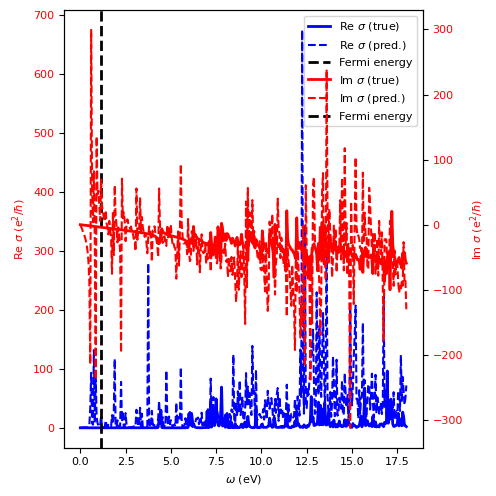

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def plot_accond_matplotlib(
    omegas_true,
    ac_cond_real_true,
    ac_cond_imag_true,
    omegas_pred=None,
    ac_cond_real_pred=None,
    ac_cond_imag_pred=None,
    filepath=None,
    ylim_real=None,
    ylim_imag=None,
    fermi_energy=None,
    legend_loc=None,
):
    """
    Plot optical conductivity with twin y-axes:
      - Real part on left (red)
      - Imaginary part on right (red)
      - Optional predicted curves (dashed)
      - Optional Fermi-energy vertical line

    Returns
    -------
    fig, (ax_real, ax_imag)
    """
    # Coerce to arrays
    omegas_true = np.asarray(omegas_true)
    ac_cond_real_true = np.asarray(ac_cond_real_true)
    ac_cond_imag_true = np.asarray(ac_cond_imag_true)

    # Basic validation
    if omegas_true.shape[0] != ac_cond_real_true.shape[0]:
        raise ValueError("omegas_true and ac_cond_real_true must have the same length.")
    if omegas_true.shape[0] != ac_cond_imag_true.shape[0]:
        raise ValueError("omegas_true and ac_cond_imag_true must have the same length.")

    # If predicted arrays are provided but no omegas_pred, assume same grid
    if (ac_cond_real_pred is not None or ac_cond_imag_pred is not None) and omegas_pred is None:
        omegas_pred = omegas_true
    if omegas_pred is not None:
        omegas_pred = np.asarray(omegas_pred)
        if ac_cond_real_pred is not None and omegas_pred.shape[0] != np.asarray(ac_cond_real_pred).shape[0]:
            raise ValueError("omegas_pred and ac_cond_real_pred must have the same length.")
        if ac_cond_imag_pred is not None and omegas_pred.shape[0] != np.asarray(ac_cond_imag_pred).shape[0]:
            raise ValueError("omegas_pred and ac_cond_imag_pred must have the same length.")

    # Figure & axes
    fig, ax_real = plt.subplots(figsize=(5, 5), facecolor="white")
    ax_real.set_facecolor("white")
    ax_imag = ax_real.twinx()

    # --- True curves ---
    line_re_true, = ax_real.plot(
        omegas_true, ac_cond_real_true,
        color="blue", lw=2, label=r"Re $\sigma$ (true)"
    )
    line_im_true, = ax_imag.plot(
        omegas_true, ac_cond_imag_true,
        color="red", lw=2, label=r"Im $\sigma$ (true)"
    )

    # --- Predicted curves (dashed) ---
    lines_pred = []
    if ac_cond_real_pred is not None:
        line_re_pred, = ax_real.plot(
            omegas_pred, np.asarray(ac_cond_real_pred),
            color="blue", lw=1.5, ls="--", label=r"Re $\sigma$ (pred.)"
        )
        lines_pred.append(line_re_pred)
    if ac_cond_imag_pred is not None:
        line_im_pred, = ax_imag.plot(
            omegas_pred, np.asarray(ac_cond_imag_pred),
            color="red", lw=1.5, ls="--", label=r"Im $\sigma$ (pred.)"
        )
        lines_pred.append(line_im_pred)

    # Optional Fermi energy (kept as in your style)
    if fermi_energy is not None:
        vline = ax_real.axvline(
            fermi_energy, color="black", ls="--", lw=2, label="Fermi energy"
        )
    else:
        vline = None

    # Axes & ticks
    ax_real.set_xlabel(r"$\omega$ (eV)")
    ax_real.set_ylabel(r"Re $\sigma$ (e$^2$/$\hbar$)", color="red")
    ax_imag.set_ylabel(r"Im $\sigma$ (e$^2$/$\hbar$)", color="red")
    ax_real.tick_params(axis="y", labelcolor="red", direction="out")
    ax_imag.tick_params(axis="y", labelcolor="red", direction="out")
    ax_real.tick_params(axis="x", direction="out")

    if ylim_real is not None:
        ax_real.set_ylim(ylim_real)
    if ylim_imag is not None:
        ax_imag.set_ylim(ylim_imag)

    # Legend (combine handles from both axes)
    handles, labels = ax_real.get_legend_handles_labels()
    h2, l2 = ax_imag.get_legend_handles_labels()
    handles += h2
    labels += l2
    if vline is not None:
        handles.append(vline)
        labels.append("Fermi energy")

    if legend_loc is None:
        legend_loc = "best"
    ax_real.legend(handles, labels, loc=legend_loc)

    fig.tight_layout()

    if filepath:
        fig.savefig(str(filepath), dpi=150, bbox_inches="tight")

    return fig, (ax_real, ax_imag)


# If your arrays are complex:
fig, (ax_real, ax_imag) = plot_accond_matplotlib(
    omegas_true,
    accond_true.real,           # Re σ (true)
    accond_true.imag,           # Im σ (true)
    omegas_pred=omegas_pred,
    ac_cond_real_pred=accond_pred.real,  # Re σ (pred)
    ac_cond_imag_pred=accond_pred.imag,  # Im σ (pred)
    filepath=None,
    ylim_real=None,
    ylim_imag=None,
    fermi_energy=fermi_thomas,
    legend_loc="upper right",
)
fig.show()

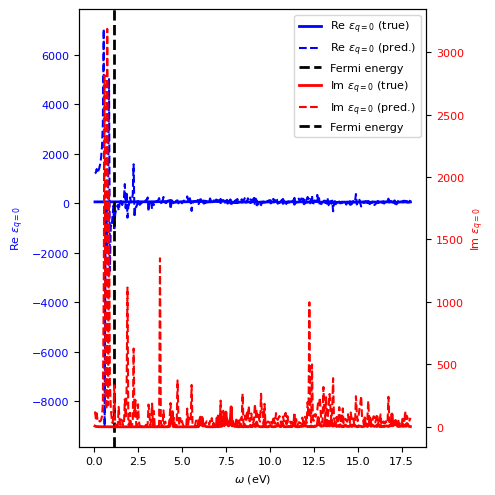

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def plot_epsq0_matplotlib(
    omegas_true,
    epsq0_true,
    omegas_pred=None,
    epsq0_pred=None,
    filepath=None,
    ylim=None,                 # if set, applies to BOTH y-axes
    fermi_energy=None,
    legend_loc=None,
    ylim_real=None,            # optional per-axis overrides
    ylim_imag=None,
):
    """
    Plot dielectric function ε_{q=0}(ω) with twin y-axes:
      - Real part on left (blue)
      - Imaginary part on right (red)
      - Optional predicted curves (dashed)
      - Optional Fermi-energy vertical line (blue dashed)

    Returns
    -------
    fig, (ax_real, ax_imag)
    """
    omegas_true = np.asarray(omegas_true)
    epsq0_true = np.asarray(epsq0_true)

    if omegas_true.shape[0] != epsq0_true.shape[0]:
        raise ValueError("omegas_true and epsq0_true must have the same length.")

    # If predicted provided but no x-grid, assume same as true
    if epsq0_pred is not None and omegas_pred is None:
        omegas_pred = omegas_true
    if omegas_pred is not None and epsq0_pred is not None:
        omegas_pred = np.asarray(omegas_pred)
        epsq0_pred = np.asarray(epsq0_pred)
        if omegas_pred.shape[0] != epsq0_pred.shape[0]:
            raise ValueError("omegas_pred and epsq0_pred must have the same length.")

    # Figure & axes
    fig, ax_real = plt.subplots(figsize=(5, 5), facecolor="white")
    ax_real.set_facecolor("white")
    ax_imag = ax_real.twinx()

    # --- True curves ---
    line_re_true, = ax_real.plot(
        omegas_true, np.real(epsq0_true),
        color="blue", lw=2, label=r"Re $\varepsilon_{q=0}$ (true)"
    )
    line_im_true, = ax_imag.plot(
        omegas_true, np.imag(epsq0_true),
        color="red", lw=2, label=r"Im $\varepsilon_{q=0}$ (true)"
    )

    # --- Predicted curves (dashed) ---
    v_pred = None
    if epsq0_pred is not None:
        ax_real.plot(
            omegas_pred, np.real(epsq0_pred),
            color="blue", lw=1.5, ls="--", label=r"Re $\varepsilon_{q=0}$ (pred.)"
        )
        ax_imag.plot(
            omegas_pred, np.imag(epsq0_pred),
            color="red", lw=1.5, ls="--", label=r"Im $\varepsilon_{q=0}$ (pred.)"
        )

    # Optional Fermi energy (kept blue dashed)
    vline = None
    if fermi_energy is not None:
        vline = ax_real.axvline(
            fermi_energy, color="black", ls="--", lw=2, label="Fermi energy"
        )

    # Axes & ticks
    ax_real.set_xlabel(r"$\omega$ (eV)")
    ax_real.set_ylabel(r"Re $\varepsilon_{q=0}$", color="blue")
    ax_imag.set_ylabel(r"Im $\varepsilon_{q=0}$", color="red")
    ax_real.tick_params(axis="y", labelcolor="blue", direction="out")
    ax_imag.tick_params(axis="y", labelcolor="red", direction="out")
    ax_real.tick_params(axis="x", direction="out")

    # y-limits
    if ylim is not None:
        ax_real.set_ylim(ylim)
        ax_imag.set_ylim(ylim)
    if ylim_real is not None:
        ax_real.set_ylim(ylim_real)
    if ylim_imag is not None:
        ax_imag.set_ylim(ylim_imag)

    # Legend (combine both axes, include vline if present)
    handles, labels = ax_real.get_legend_handles_labels()
    h2, l2 = ax_imag.get_legend_handles_labels()
    handles += h2
    labels += l2
    if vline is not None:
        handles.append(vline)
        labels.append("Fermi energy")

    if legend_loc is None:
        legend_loc = "best"
    ax_real.legend(handles, labels, loc=legend_loc)

    fig.tight_layout()

    if filepath:
        fig.savefig(str(filepath), dpi=150, bbox_inches="tight")

    return fig, (ax_real, ax_imag)


fig, (ax_real, ax_imag) = plot_epsq0_matplotlib(
    omegas_true,
    epsq0_true,                       # complex array: ε(ω)
    omegas_pred=omegas_pred,
    epsq0_pred=epsq0_pred,            # complex array: ε̂(ω)
    filepath=None,
    ylim=None,                        # or e.g., (-5, 15)
    fermi_energy=fermi_thomas,
    legend_loc="upper right",
)
fig.show()
